# CIFAR-10 — Colab Quickstart (EAUT)
Chọn **Runtime → Change runtime type → GPU**, rồi chạy các cell từ trên xuống.


In [2]:
!pip -q install -U scikit-learn matplotlib pandas thop


In [3]:
# Tạo thư mục dự án và ghi file .py vào Colab
import os
root="/content/cifar10_pack"; os.makedirs(root, exist_ok=True)
open(f"{root}/train_cifar10.py","w").write('\n# train_cifar10.py\nimport os, json, random, argparse, time\nimport numpy as np, torch, torch.nn as nn, torch.nn.functional as F\nfrom torch.utils.data import DataLoader, random_split\nfrom torchvision import datasets, transforms, models\nfrom torch.optim.lr_scheduler import CosineAnnealingLR, StepLR\nfrom sklearn.metrics import f1_score\n\nclass SimpleCNN(nn.Module):\n    def __init__(self, num_classes=10):\n        super().__init__()\n        self.features = nn.Sequential(\n            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),\n            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),\n            nn.MaxPool2d(2),\n            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),\n            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),\n            nn.MaxPool2d(2),\n            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),\n            nn.MaxPool2d(2),\n        )\n        self.classifier = nn.Sequential(\n            nn.Dropout(0.3), nn.Linear(128*4*4,256), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.Linear(256,num_classes)\n        )\n    def forward(self,x): x=self.features(x); x=x.view(x.size(0),-1); return self.classifier(x)\n\ndef build_model(name, num_classes=10):\n    name = name.lower()\n    if name=="simplecnn": return SimpleCNN(num_classes)\n    if name=="resnet18":\n        m=models.resnet18(weights=None); m.fc=nn.Linear(m.fc.in_features,num_classes); return m\n    if name=="mobilenetv2":\n        m=models.mobilenet_v2(weights=None); m.classifier[1]=nn.Linear(m.last_channel,num_classes); return m\n    if name=="efficientnet_b0":\n        m=models.efficientnet_b0(weights=None); m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes); return m\n    if name=="vgg11_bn":\n        m=models.vgg11_bn(weights=None); m.classifier[6]=nn.Linear(m.classifier[6].in_features,num_classes); return m\n    raise ValueError("Unknown model")\n\ndef loaders(root, batch=128, val_ratio=0.1, seed=42, aug=True, workers=2):\n    mean=(0.4914,0.4822,0.4465); std=(0.2470,0.2435,0.2616)\n    tf_train=[transforms.RandomCrop(32,padding=4), transforms.RandomHorizontalFlip()] if aug else []\n    tf_train += [transforms.ToTensor(), transforms.Normalize(mean,std)]\n    tf_test = [transforms.ToTensor(), transforms.Normalize(mean,std)]\n    train_full=datasets.CIFAR10(root=root, train=True, download=True, transform=transforms.Compose(tf_train))\n    test_set  =datasets.CIFAR10(root=root, train=False, download=True, transform=transforms.Compose(tf_test))\n    g=torch.Generator().manual_seed(seed); n=len(train_full); n_val=int(n*val_ratio); n_train=n-n_val\n    train_set, val_set = random_split(train_full, [n_train, n_val], generator=g)\n    mk=lambda ds,sh: DataLoader(ds,batch_size=batch,shuffle=sh,num_workers=workers,pin_memory=True)\n    return mk(train_set,True), mk(val_set,False), mk(test_set,False)\n\n@torch.no_grad()\ndef evaluate(m, dl, dev):\n    m.eval(); tot=correct=0; loss_sum=0.0; ys=[]; ps=[]\n    for x,y in dl:\n        x,y=x.to(dev), y.to(dev); logits=m(x); loss=F.cross_entropy(logits,y)\n        loss_sum += loss.item()*y.size(0); pred=logits.argmax(1); correct+=(pred==y).sum().item(); tot+=y.size(0)\n        ys.append(y.cpu()); ps.append(pred.cpu())\n    y_true=torch.cat(ys).numpy(); y_pred=torch.cat(ps).numpy()\n    f1=f1_score(y_true,y_pred,average="macro"); return loss_sum/tot, correct/tot, f1\n\ndef train(args):\n    os.makedirs(args.outdir, exist_ok=True); dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    tr, va, te = loaders(args.data_root, args.batch, args.val_ratio, args.seed, not args.no_aug, args.num_workers)\n    m = build_model(args.model, 10).to(dev)\n    opt = torch.optim.SGD(m.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.wd) if args.opt=="sgd" else torch.optim.AdamW(m.parameters(), lr=args.lr, weight_decay=args.wd)\n    sch = CosineAnnealingLR(opt, T_max=args.epochs) if args.sched=="cosine" else (StepLR(opt, step_size=args.step_size, gamma=args.gamma) if args.sched=="step" else None)\n    scaler = torch.cuda.amp.GradScaler() if (args.amp and dev.type=="cuda") else None\n\n    open(os.path.join(args.outdir,"train_log.csv"),"w").write("epoch,train_loss,train_acc,val_loss,val_acc,val_f1,lr\\\\n")\n    best= -1.0\n    for ep in range(1, args.epochs+1):\n        m.train(); tot=correct=0; loss_sum=0.0\n        for x,y in tr:\n            x,y=x.to(dev), y.to(dev); opt.zero_grad(set_to_none=True)\n            if scaler:\n                with torch.autocast(device_type=dev.type, enabled=True):\n                    logits=m(x); loss=F.cross_entropy(logits,y,label_smoothing=0.1)\n                scaler.scale(loss).backward(); scaler.step(opt); scaler.update()\n            else:\n                logits=m(x); loss=F.cross_entropy(logits,y,label_smoothing=0.1)\n                loss.backward(); opt.step()\n            loss_sum+=loss.item()*y.size(0); correct+=(logits.argmax(1)==y).sum().item(); tot+=y.size(0)\n        tl, ta = loss_sum/tot, correct/tot\n        vl, va, vf1 = evaluate(m, va, dev)\n        if sch: sch.step()\n        with open(os.path.join(args.outdir,"train_log.csv"),"a") as f:\n            f.write(f"{ep},{tl:.6f},{ta:.6f},{vl:.6f},{va:.6f},{vf1:.6f},{opt.param_groups[0][\'lr\']:.6f}\\\\n")\n        if va>best: best=va; torch.save({"model":m.state_dict(),"epoch":ep,"val_acc":va}, os.path.join(args.outdir,"best.pt"))\n        print(f"[{ep:03d}/{args.epochs}] train_acc={ta:.4f} val_acc={va:.4f} val_f1={vf1:.4f}")\n    # test\n    ckpt=torch.load(os.path.join(args.outdir,"best.pt"), map_location=dev); m.load_state_dict(ckpt["model"])\n    tl, ta, tf1 = evaluate(m, te, dev)\n    print("TEST:", ta, tf1)\n\nif __name__=="__main__":\n    ap=argparse.ArgumentParser()\n    ap.add_argument("--data_root", type=str, default="/content/data")\n    ap.add_argument("--outdir", type=str, default="/content/runs/resnet18_c10")\n    ap.add_argument("--model", type=str, default="resnet18", choices=["simplecnn","resnet18","mobilenetv2","efficientnet_b0","vgg11_bn"])\n    ap.add_argument("--epochs", type=int, default=20); ap.add_argument("--batch", type=int, default=128)\n    ap.add_argument("--opt", type=str, default="sgd", choices=["sgd","adamw"]); ap.add_argument("--lr", type=float, default=0.1); ap.add_argument("--wd", type=float, default=5e-4)\n    ap.add_argument("--sched", type=str, default="cosine", choices=["cosine","step","none"]); ap.add_argument("--step_size", type=int, default=30); ap.add_argument("--gamma", type=float, default=0.1)\n    ap.add_argument("--val_ratio", type=float, default=0.1); ap.add_argument("--seed", type=int, default=42); ap.add_argument("--num_workers", type=int, default=2)\n    ap.add_argument("--no_aug", action="store_true"); ap.add_argument("--amp", action="store_true")\n    args=ap.parse_args(); train(args)\n')
open(f"{root}/eval_cifar10.py","w").write('\n# eval_cifar10.py\nimport os, argparse, numpy as np, torch, torch.nn as nn, time, json\nfrom torchvision import datasets, transforms, models\nfrom sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score\nimport matplotlib.pyplot as plt\n\ndef build_model(name, num_classes=10):\n    name=name.lower()\n    if name=="resnet18":\n        m=models.resnet18(weights=None); m.fc=nn.Linear(m.fc.in_features,num_classes); return m\n    if name=="mobilenetv2":\n        m=models.mobilenet_v2(weights=None); m.classifier[1]=nn.Linear(m.last_channel,num_classes); return m\n    if name=="efficientnet_b0":\n        m=models.efficientnet_b0(weights=None); m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes); return m\n    if name=="vgg11_bn":\n        m=models.vgg11_bn(weights=None); m.classifier[6]=nn.Linear(m.classifier[6].in_features,num_classes); return m\n    from train_cifar10 import SimpleCNN\n    if name=="simplecnn": return SimpleCNN(num_classes)\n    raise ValueError("Unknown model")\n\ndef main():\n    ap=argparse.ArgumentParser()\n    ap.add_argument("--data_root", type=str, default="/content/data")\n    ap.add_argument("--checkpoint", type=str, required=True)\n    ap.add_argument("--model", type=str, required=True, choices=["simplecnn","resnet18","mobilenetv2","efficientnet_b0","vgg11_bn"])\n    ap.add_argument("--outdir", type=str, default="/content/runs/eval"); ap.add_argument("--batch", type=int, default=256)\n    args=ap.parse_args()\n\n    os.makedirs(args.outdir, exist_ok=True); dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    mean=(0.4914,0.4822,0.4465); std=(0.2470,0.2435,0.2616)\n    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])\n    test_set = datasets.CIFAR10(root=args.data_root, train=False, download=True, transform=tfm)\n    test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch, shuffle=False, num_workers=2, pin_memory=True)\n\n    m = build_model(args.model,10).to(dev); ckpt=torch.load(args.checkpoint, map_location=dev); m.load_state_dict(ckpt["model"]); m.eval()\n    ys, ps = [], []\n    with torch.no_grad():\n        for x,y in test_loader:\n            x,y=x.to(dev), y.to(dev); pred=m(x).argmax(1)\n            ys.append(y.cpu().numpy()); ps.append(pred.cpu().numpy())\n    y=np.concatenate(ys); p=np.concatenate(ps)\n    acc=accuracy_score(y,p); f1m=f1_score(y,p,average="macro")\n    print(f"Test Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}"); print(classification_report(y,p,digits=4))\n\n    cm=confusion_matrix(y,p); fig=plt.figure(); plt.imshow(cm); plt.title("Confusion Matrix (CIFAR-10)")\n    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()\n    for (i,j),z in np.ndenumerate(cm): plt.text(j,i,str(z),ha=\'center\',va=\'center\')\n    cm_path=os.path.join(args.outdir,"confusion_matrix.png"); fig.savefig(cm_path,dpi=300,bbox_inches="tight"); print("Saved:", cm_path)\n\n    params_m = sum(p.numel() for p in m.parameters() if p.requires_grad)/1e6\n    try:\n        from thop import profile\n        x=torch.randn(1,3,32,32).to(dev); flops,_=profile(m, inputs=(x,), verbose=False); flops_g=flops/1e9\n    except Exception: flops_g=None\n\n    def measure(mod, dev, iters=100, warmup=30):\n        x=torch.randn(1,3,32,32).to(dev)\n        for _ in range(warmup): _=mod(x)\n        if dev.type=="cuda": torch.cuda.synchronize()\n        t0=time.time()\n        for _ in range(iters): _=mod(x)\n        if dev.type=="cuda": torch.cuda.synchronize()\n        return (time.time()-t0)*1000/iters\n\n    m_cpu = build_model(args.model,10).to("cpu"); m_cpu.load_state_dict(ckpt["model"], strict=False)\n    lat_cpu=measure(m_cpu, torch.device("cpu")); lat_gpu=None\n    if torch.cuda.is_available(): lat_gpu=measure(m, dev)\n\n    summary={"model":args.model,"dataset":"cifar10","test_acc":round(acc,4),"test_f1":round(f1m,4),\n             "params_m":round(params_m,4),"flops_g":(round(flops_g,4) if flops_g is not None else None),\n             "latency_cpu_ms":round(lat_cpu,4),"latency_gpu_ms":(round(lat_gpu,4) if lat_gpu is not None else None),\n             "checkpoint":args.checkpoint}\n    json.dump(summary, open(os.path.join(args.outdir,"eval_summary.json"),"w"), indent=2); print("Saved eval summary to eval_summary.json")\n\nif __name__=="__main__": main()\n')
print("Wrote files:", os.listdir(root))
%cd /content/cifar10_pack


Wrote files: ['train_cifar10.py', 'eval_cifar10.py']
/content/cifar10_pack


In [4]:
# HOTFIX: overwrite train_cifar10.py with a safe version (no variable name collision)
fixed = r'''
import os, json, random, argparse, time
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from sklearn.metrics import f1_score

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(128*4*4,256), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.Linear(256,num_classes)
        )
    def forward(self,x): x=self.features(x); x=x.view(x.size(0),-1); return self.classifier(x)

def build_model(name, num_classes=10):
    name = name.lower()
    if name=="simplecnn": return SimpleCNN(num_classes)
    if name=="resnet18":
        m=models.resnet18(weights=None); m.fc=nn.Linear(m.fc.in_features,num_classes); return m
    if name=="mobilenetv2":
        m=models.mobilenet_v2(weights=None); m.classifier[1]=nn.Linear(m.last_channel,num_classes); return m
    if name=="efficientnet_b0":
        m=models.efficientnet_b0(weights=None); m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes); return m
    if name=="vgg11_bn":
        m=models.vgg11_bn(weights=None); m.classifier[6]=nn.Linear(m.classifier[6].in_features,num_classes); return m
    raise ValueError("Unknown model")

def loaders(root, batch=128, val_ratio=0.1, seed=42, aug=True, workers=2):
    mean=(0.4914,0.4822,0.4465); std=(0.2470,0.2435,0.2616)
    tf_train=[transforms.RandomCrop(32,padding=4), transforms.RandomHorizontalFlip()] if aug else []
    tf_train += [transforms.ToTensor(), transforms.Normalize(mean,std)]
    tf_test = [transforms.ToTensor(), transforms.Normalize(mean,std)]
    train_full=datasets.CIFAR10(root=root, train=True, download=True, transform=transforms.Compose(tf_train))
    test_set  =datasets.CIFAR10(root=root, train=False, download=True, transform=transforms.Compose(tf_test))
    g=torch.Generator().manual_seed(seed); n=len(train_full); n_val=int(n*val_ratio); n_train=n-n_val
    train_set, val_set = random_split(train_full, [n_train, n_val], generator=g)
    mk=lambda ds,sh: DataLoader(ds,batch_size=batch,shuffle=sh,num_workers=workers,pin_memory=True)
    return mk(train_set,True), mk(val_set,False), mk(test_set,False)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); tot=correct=0; loss_sum=0.0; ys=[]; ps=[]
    for x,y in loader:
        x,y=x.to(device), y.to(device); logits=model(x); loss=F.cross_entropy(logits,y)
        loss_sum += loss.item()*y.size(0); pred=logits.argmax(1)
        correct += (pred==y).sum().item(); tot += y.size(0)
        ys.append(y.cpu()); ps.append(pred.cpu())
    y_true=torch.cat(ys).numpy(); y_pred=torch.cat(ps).numpy()
    f1=f1_score(y_true,y_pred,average="macro")
    return loss_sum/tot, correct/tot, f1

def train(args):
    os.makedirs(args.outdir, exist_ok=True)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = loaders(args.data_root, args.batch, args.val_ratio, args.seed, not args.no_aug, args.num_workers)
    model = build_model(args.model, 10).to(device)
    if args.opt=="sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.wd, nesterov=True)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs) if args.sched=="cosine" else (StepLR(optimizer, step_size=args.step_size, gamma=args.gamma) if args.sched=="step" else None)
    scaler = torch.cuda.amp.GradScaler() if (args.amp and device.type=="cuda") else None

    open(os.path.join(args.outdir,"train_log.csv"),"w").write("epoch,train_loss,train_acc,val_loss,val_acc,val_f1,lr\\n")
    best_acc=-1.0
    for ep in range(1, args.epochs+1):
        model.train(); tot=correct=0; loss_sum=0.0
        for x,y in train_loader:
            x,y=x.to(device), y.to(device); optimizer.zero_grad(set_to_none=True)
            if scaler:
                with torch.autocast(device_type=device.type, enabled=True):
                    logits=model(x); loss=F.cross_entropy(logits,y,label_smoothing=0.1)
                scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            else:
                logits=model(x); loss=F.cross_entropy(logits,y,label_smoothing=0.1)
                loss.backward(); optimizer.step()
            loss_sum += loss.item()*y.size(0); correct += (logits.argmax(1)==y).sum().item(); tot += y.size(0)
        train_loss, train_acc = loss_sum/tot, correct/tot

        val_loss, val_acc, val_f1 = evaluate(model, val_loader, device)
        if scheduler: scheduler.step()

        with open(os.path.join(args.outdir,"train_log.csv"),"a") as f:
            f.write(f"{ep},{train_loss:.6f},{train_acc:.6f},{val_loss:.6f},{val_acc:.6f},{val_f1:.6f},{optimizer.param_groups[0]['lr']:.6f}\\n")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({"model":model.state_dict(),"epoch":ep,"val_acc":val_acc}, os.path.join(args.outdir,"best.pt"))

        print(f"[{ep:03d}/{args.epochs}] train_acc={train_acc:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

    # Test cuối
    ckpt=torch.load(os.path.join(args.outdir,"best.pt"), map_location=device)
    model.load_state_dict(ckpt["model"])
    test_loss, test_acc, test_f1 = evaluate(model, test_loader, device)
    print("TEST:", test_acc, test_f1)

if __name__=="__main__":
    ap=argparse.ArgumentParser()
    ap.add_argument("--data_root", type=str, default="/content/data")
    ap.add_argument("--outdir", type=str, default="/content/runs/resnet18_c10")
    ap.add_argument("--model", type=str, default="resnet18", choices=["simplecnn","resnet18","mobilenetv2","efficientnet_b0","vgg11_bn"])
    ap.add_argument("--epochs", type=int, default=20); ap.add_argument("--batch", type=int, default=128)
    ap.add_argument("--opt", type=str, default="sgd", choices=["sgd","adamw"]); ap.add_argument("--lr", type=float, default=0.1); ap.add_argument("--wd", type=float, default=5e-4)
    ap.add_argument("--sched", type=str, default="cosine", choices=["cosine","step","none"]); ap.add_argument("--step_size", type=int, default=30); ap.add_argument("--gamma", type=float, default=0.1)
    ap.add_argument("--val_ratio", type=float, default=0.1); ap.add_argument("--seed", type=int, default=42); ap.add_argument("--num_workers", type=int, default=2)
    ap.add_argument("--no_aug", action="store_true"); ap.add_argument("--amp", action="store_true")
    args=ap.parse_args(); train(args)
'''
open("/content/cifar10_pack/train_cifar10.py","w").write(fixed)
print("Patched /content/cifar10_pack/train_cifar10.py")


Patched /content/cifar10_pack/train_cifar10.py


In [5]:
# Patch GradScaler & autocast sang API mới (torch.amp.*)
import pathlib, re
p = pathlib.Path("/content/cifar10_pack/train_cifar10.py")
s = p.read_text()

# GradScaler: torch.cuda.amp.GradScaler()  ->  torch.amp.GradScaler('cuda')
s = re.sub(r"torch\.cuda\.amp\.GradScaler\(\)",
           "torch.amp.GradScaler('cuda')", s)

# autocast: with torch.autocast(device_type=device.type, enabled=True): -> with torch.amp.autocast('cuda'):
s = s.replace("with torch.autocast(device_type=device.type, enabled=True):",
              "with torch.amp.autocast('cuda'):")

p.write_text(s)
print("Patched:", p)


Patched: /content/cifar10_pack/train_cifar10.py


In [10]:
# HOTFIX: set eval() + no_grad() when measuring latency
import pathlib, re
p = pathlib.Path("/content/cifar10_pack/eval_cifar10.py")
s = p.read_text()

# 1) Sửa hàm measure(...) để dùng eval() + no_grad()
s = re.sub(
r"def measure\(.*?\):.*?return .*?\n",
"""def measure(m, dev, iters=200, warmup=50):
    m.eval()
    x = torch.randn(1,3,32,32).to(dev)
    with torch.no_grad():
        for _ in range(warmup):
            _ = m(x)
        if dev.type == "cuda":
            torch.cuda.synchronize()
        import time
        t0 = time.time()
        for _ in range(iters):
            _ = m(x)
        if dev.type == "cuda":
            torch.cuda.synchronize()
    return (time.time() - t0) * 1000.0 / iters
""", s, flags=re.S)

# 2) Đảm bảo m_cpu cũng eval() trước khi đo
s = s.replace(
    'm_cpu = build_model(args.model, num_classes=10).to("cpu")\n    m_cpu.load_state_dict(ckpt["model"], strict=False)\n    lat_cpu = measure(m_cpu, torch.device("cpu"))',
    'm_cpu = build_model(args.model, num_classes=10).to("cpu")\n    m_cpu.load_state_dict(ckpt["model"], strict=False)\n    m_cpu.eval()\n    lat_cpu = measure(m_cpu, torch.device("cpu"))'
)

p.write_text(s)
print("Patched:", p)


Patched: /content/cifar10_pack/eval_cifar10.py


In [15]:
code = r'''
import os, argparse, json, time, numpy as np
import torch, torch.nn as nn
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

def build_model(name: str, num_classes=10):
    name = name.lower()
    if name == "resnet18":
        m = models.resnet18(weights=None); m.fc = nn.Linear(m.fc.in_features, num_classes); return m
    if name == "mobilenetv2":
        m = models.mobilenet_v2(weights=None); m.classifier[1] = nn.Linear(m.last_channel, num_classes); return m
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights=None); m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes); return m
    if name == "vgg11_bn":
        m = models.vgg11_bn(weights=None); m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes); return m
    # SimpleCNN lấy từ train_cifar10.py
    try:
        from train_cifar10 import SimpleCNN
        if name == "simplecnn": return SimpleCNN(num_classes)
    except Exception:
        pass
    raise ValueError(f"Unknown model: {name}")

def measure(m, dev, iters=200, warmup=50):
    m.eval()
    x = torch.randn(1,3,32,32).to(dev)
    with torch.no_grad():
        for _ in range(warmup):
            _ = m(x)
        if dev.type == "cuda": torch.cuda.synchronize()
        t0 = time.time()
        for _ in range(iters):
            _ = m(x)
        if dev.type == "cuda": torch.cuda.synchronize()
    return (time.time() - t0) * 1000.0 / iters

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_root", type=str, default="/content/data")
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--model", type=str, required=True,
                    choices=["simplecnn","resnet18","mobilenetv2","efficientnet_b0","vgg11_bn"])
    ap.add_argument("--outdir", type=str, default="/content/runs/eval")
    ap.add_argument("--batch", type=int, default=256)
    args = ap.parse_args()

    os.makedirs(args.outdir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    mean=(0.4914,0.4822,0.4465); std=(0.2470,0.2435,0.2616)
    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
    test_set = datasets.CIFAR10(root=args.data_root, train=False, download=True, transform=tfm)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch, shuffle=False, num_workers=2, pin_memory=True)

    model = build_model(args.model, 10).to(device)
    ckpt = torch.load(args.checkpoint, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()

    ys, ps = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            ys.append(y.cpu().numpy()); ps.append(pred.cpu().numpy())
    y = np.concatenate(ys); p = np.concatenate(ps)

    acc = accuracy_score(y, p); f1m = f1_score(y, p, average="macro")
    print(f"Test Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}")
    print(classification_report(y, p, digits=4))

    cm = confusion_matrix(y, p)
    fig = plt.figure()
    plt.imshow(cm); plt.title("Confusion Matrix (CIFAR-10)")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
    for (i,j), z in np.ndenumerate(cm): plt.text(j,i,str(z),ha='center',va='center')
    cm_path = os.path.join(args.outdir, "confusion_matrix.png")
    fig.savefig(cm_path, dpi=300, bbox_inches="tight")
    print("Saved:", cm_path)

    params_m = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    try:
        from thop import profile
        x = torch.randn(1,3,32,32).to(device)
        flops, _ = profile(model, inputs=(x,), verbose=False)
        flops_g = flops/1e9
    except Exception:
        flops_g = None

    # Latency (CPU luôn có; GPU nếu có CUDA)
    m_cpu = build_model(args.model, 10).to("cpu")
    m_cpu.load_state_dict(ckpt["model"], strict=False)
    lat_cpu = measure(m_cpu, torch.device("cpu"))
    lat_gpu = measure(model, device) if torch.cuda.is_available() else None

    summary = {
        "model": args.model, "dataset": "cifar10",
        "test_acc": round(acc,4), "test_f1": round(f1m,4),
        "params_m": round(params_m,4),
        "flops_g": round(flops_g,4) if flops_g is not None else None,
        "latency_cpu_ms": round(lat_cpu,4),
        "latency_gpu_ms": round(lat_gpu,4) if lat_gpu is not None else None,
        "checkpoint": args.checkpoint
    }
    with open(os.path.join(args.outdir, "eval_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)
    print("Saved eval summary to eval_summary.json")

if __name__ == "__main__":
    main()
'''
open("/content/cifar10_pack/eval_cifar10.py","w").write(code)
print("Wrote /content/cifar10_pack/eval_cifar10.py")


Wrote /content/cifar10_pack/eval_cifar10.py


In [21]:
!tail -n +1 /content/runs/*_c10/train_log.csv | sed -n '1,10p'


epoch,train_loss,train_acc,val_loss,val_acc,val_f1,lr\n1,2.146670,0.308956,1.648304,0.409000,0.394808,0.099384\n2,1.666595,0.460844,1.420725,0.494800,0.488285,0.097553\n3,1.493540,0.543600,1.320597,0.530800,0.536557,0.094550\n4,1.383742,0.595378,1.214788,0.578000,0.566483,0.090451\n5,1.307539,0.635156,1.135086,0.614000,0.607521,0.085355\n6,1.253598,0.663422,1.057930,0.648000,0.642929,0.079389\n7,1.205386,0.682178,1.054808,0.643200,0.646991,0.072700\n8,1.168963,0.702978,0.957623,0.677800,0.679268,0.065451\n9,1.131694,0.718711,0.939067,0.687000,0.688164,0.057822\n10,1.094680,0.735511,0.872176,0.708200,0.706145,0.050000\n11,1.062007,0.746333,0.845716,0.710600,0.709411,0.042178\n12,1.027813,0.765489,0.843526,0.721200,0.723114,0.034549\n13,0.998087,0.778378,0.735842,0.766000,0.763847,0.027300\n14,0.962805,0.794667,0.765341,0.752400,0.754316,0.020611\n15,0.931763,0.809533,0.699142,0.776800,0.778365,0.014645\n16,0.895823,0.823667,0.666661,0.786400,0.784097,0.009549\n17,0.862983,0.838067,0.639

In [22]:
# Sửa train_cifar10.py: đổi tất cả "\\n" trong chuỗi ghi file thành "\n"
from pathlib import Path
p = Path("/content/cifar10_pack/train_cifar10.py")
s = p.read_text()
s = s.replace("\\\\n", "\\n")   # "\\n" (2 ký tự) -> "\n"
p.write_text(s)
print("Patched:", p)


Patched: /content/cifar10_pack/train_cifar10.py


Fixed newlines in /content/runs/resnet18_c10/train_log.csv


'/content/runs/resnet18_c10/acc_curve.png'

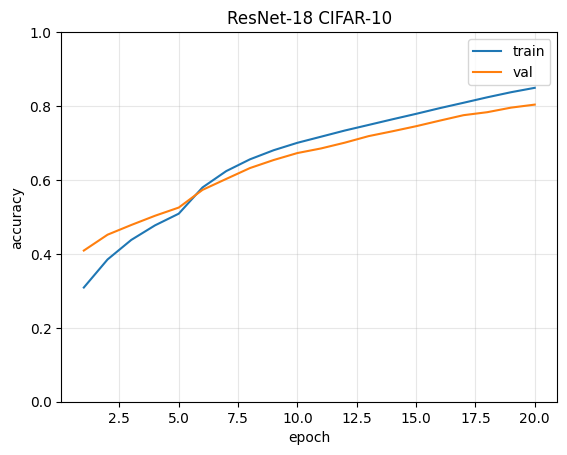

In [23]:
# 2.1 Chuyển các ký tự "\n" literal trong CSV thành xuống dòng thật
log = "/content/runs/resnet18_c10/train_log.csv"
with open(log, "r", encoding="utf-8") as f:
    txt = f.read()
if "\\n" in txt:
    txt = txt.replace("\\n", "\n")
with open(log, "w", encoding="utf-8", newline="\n") as f:
    f.write(txt)
print("Fixed newlines in", log)

# 2.2 Đọc & vẽ lại (đặt trục Y 0..1 cho rõ)
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv(log)
for c in ["epoch","train_acc","val_acc","train_loss","val_loss"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["train_acc_smooth"] = df["train_acc"].rolling(5, min_periods=1).mean()
df["val_acc_smooth"]   = df["val_acc"].rolling(5, min_periods=1).mean()

plt.figure()
plt.plot(df["epoch"], df["train_acc_smooth"], label="train")
plt.plot(df["epoch"], df["val_acc_smooth"],   label="val")
plt.ylim(0, 1.0); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.title("ResNet-18 CIFAR-10"); plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig("/content/runs/resnet18_c10/acc_curve.png", dpi=200, bbox_inches="tight")
"/content/runs/resnet18_c10/acc_curve.png"


epoch           int64
train_loss    float64
train_acc     float64
val_loss      float64
val_acc       float64
val_f1        float64
lr            float64
dtype: object
   epoch  train_loss  train_acc  val_loss  val_acc    val_f1        lr
0      1    2.146670   0.308956  1.648304   0.4090  0.394808  0.099384
1      2    1.666595   0.460844  1.420725   0.4948  0.488285  0.097553
2      3    1.493540   0.543600  1.320597   0.5308  0.536557  0.094550
3      4    1.383742   0.595378  1.214788   0.5780  0.566483  0.090451
4      5    1.307539   0.635156  1.135086   0.6140  0.607521  0.085355
Saved -> /content/runs/resnet18_c10/acc_curve.png
Saved -> /content/runs/resnet18_c10/loss_curve.png


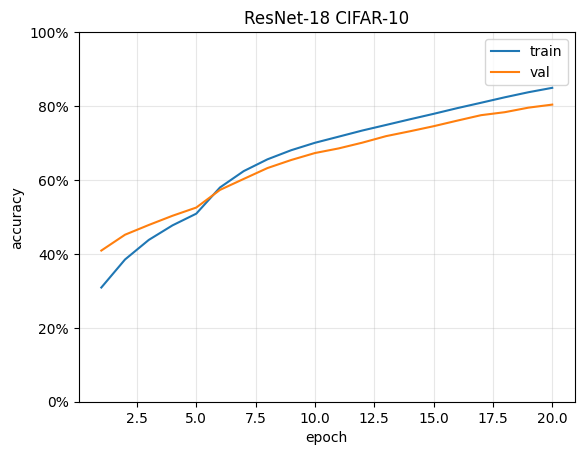

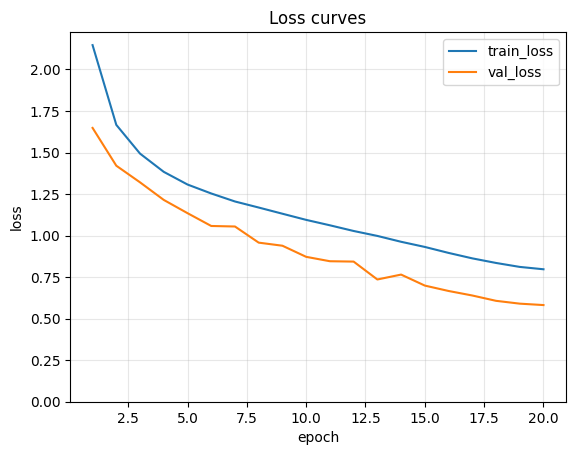

In [24]:
import pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

log = "/content/runs/resnet18_c10/train_log.csv"
df = pd.read_csv(log)
print(df.dtypes)
print(df.head())

# Ép kiểu số đề phòng bị đọc thành chuỗi
for c in ["epoch","train_acc","val_acc","train_loss","val_loss"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# (tuỳ chọn) làm mượt để nhìn mượt hơn
df["train_acc_smooth"] = df["train_acc"].rolling(5, min_periods=1).mean()
df["val_acc_smooth"]   = df["val_acc"].rolling(5, min_periods=1).mean()

# Vẽ ACC
plt.figure()
plt.plot(df["epoch"], df["train_acc_smooth"], label="train")
plt.plot(df["epoch"], df["val_acc_smooth"],   label="val")
plt.ylim(0, 1.0)                          # ép trục Y 0..1
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))  # hiển thị dạng %
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("ResNet-18 CIFAR-10")
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig("/content/runs/resnet18_c10/acc_curve.png", dpi=200, bbox_inches="tight")
print("Saved -> /content/runs/resnet18_c10/acc_curve.png")

# Vẽ LOSS (tham khảo)
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"],   label="val_loss")
plt.ylim(bottom=0); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curves")
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig("/content/runs/resnet18_c10/loss_curve.png", dpi=200, bbox_inches="tight")
print("Saved -> /content/runs/resnet18_c10/loss_curve.png")


In [25]:
# Huấn luyện ResNet-18 (demo 20 epochs). Tăng 60-100 epoch khi lấy số cho bài báo.
!python train_cifar10.py --model resnet18 --epochs 60 --batch 128 --opt sgd --lr 0.1 --wd 5e-4 --sched cosine --amp --outdir /content/runs/resnet18_c10


[001/60] train_acc=0.2549 val_acc=0.3726 val_f1=0.3384
[002/60] train_acc=0.4192 val_acc=0.4388 val_f1=0.4264
[003/60] train_acc=0.4903 val_acc=0.5014 val_f1=0.4983
[004/60] train_acc=0.5519 val_acc=0.5410 val_f1=0.5375
[005/60] train_acc=0.6041 val_acc=0.5908 val_f1=0.5827
[006/60] train_acc=0.6397 val_acc=0.6218 val_f1=0.6187
[007/60] train_acc=0.6636 val_acc=0.6212 val_f1=0.6205
[008/60] train_acc=0.6822 val_acc=0.6392 val_f1=0.6428
[009/60] train_acc=0.6955 val_acc=0.6658 val_f1=0.6627
[010/60] train_acc=0.7068 val_acc=0.6758 val_f1=0.6718
[011/60] train_acc=0.7172 val_acc=0.6730 val_f1=0.6614
[012/60] train_acc=0.7242 val_acc=0.6956 val_f1=0.6933
[013/60] train_acc=0.7271 val_acc=0.6728 val_f1=0.6736
[014/60] train_acc=0.7360 val_acc=0.6920 val_f1=0.6908
[015/60] train_acc=0.7466 val_acc=0.7128 val_f1=0.7124
[016/60] train_acc=0.7511 val_acc=0.7154 val_f1=0.7158
[017/60] train_acc=0.7526 val_acc=0.7198 val_f1=0.7202
[018/60] train_acc=0.7593 val_acc=0.7462 val_f1=0.7422
[019/60] t

In [26]:
# Đánh giá + ma trận nhầm lẫn + tóm tắt
!python eval_cifar10.py --checkpoint /content/runs/resnet18_c10/best.pt --model resnet18 --outdir /content/runs/resnet18_c10


Test Accuracy: 0.8635 | F1-macro: 0.8634
              precision    recall  f1-score   support

           0     0.8642    0.8910    0.8774      1000
           1     0.9335    0.9260    0.9297      1000
           2     0.8473    0.8100    0.8282      1000
           3     0.7236    0.7250    0.7243      1000
           4     0.8482    0.8660    0.8570      1000
           5     0.7876    0.7860    0.7868      1000
           6     0.9000    0.9090    0.9045      1000
           7     0.9107    0.8870    0.8987      1000
           8     0.9222    0.9240    0.9231      1000
           9     0.8984    0.9110    0.9047      1000

    accuracy                         0.8635     10000
   macro avg     0.8636    0.8635    0.8634     10000
weighted avg     0.8636    0.8635    0.8634     10000

Saved: /content/runs/resnet18_c10/confusion_matrix.png
Saved eval summary to eval_summary.json


Saved curve to /content/runs/resnet18_c10/acc_curve.png


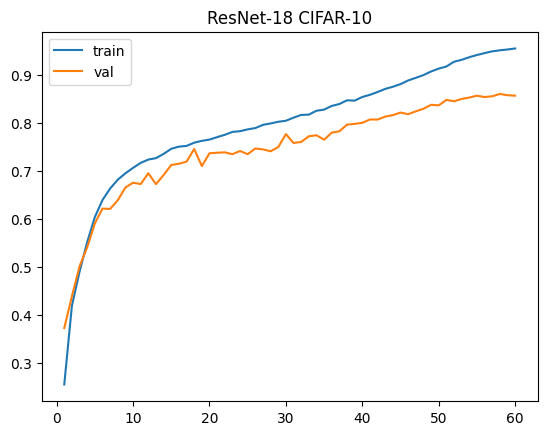

In [27]:
# Vẽ đường cong học
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("/content/runs/resnet18_c10/train_log.csv")
plt.figure(); plt.plot(df.epoch, df.train_acc, label="train"); plt.plot(df.epoch, df.val_acc, label="val"); plt.legend(); plt.title("ResNet-18 CIFAR-10")
plt.savefig("/content/runs/resnet18_c10/acc_curve.png", dpi=200); print("Saved curve to /content/runs/resnet18_c10/acc_curve.png")
